# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from sklearn.metrics import confusion_matrix


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify').getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1613438959016'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '0b0fb20874b5'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.port', '33931')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#load dataset
path = 'mini_sparkify_event_data.json'
user_log = spark.read.json(path)

In [6]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [8]:
user_log.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [9]:
#verify how many rows the file we are working on has
user_log.count()

286500

In [10]:
#verify how many columns the file we are working on has
print(len(user_log.columns))

18


In [11]:
#count the number of missing values in each of the columns of the database that is being worked on
user_log.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in user_log.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


In [12]:
#count of the feature 'page' of what a user is doing
user_log.groupby('page').count().toPandas()

,page,count
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


In [13]:
user_log.groupby('auth').count().toPandas()

,auth,count
0,Logged Out,8249
1,Cancelled,52
2,Guest,97
3,Logged In,278102


In [14]:
# there are no NA values
df = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [15]:
df.count()

286500

In [16]:
user_log.select("userId").dropDuplicates().sort("userId")

DataFrame[userId: string]

In [17]:
# the "userId" that are empty are removed
df = df.filter(df["userId"] != "")

In [18]:
df.count()

278154

In [19]:
#empty user and guest user values are removed and assigned to a dataframe
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,50046,0,0,0,0,0,50046,0,0,0,0,0,0,50046,0,0,0,0


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
df.select("page").dropDuplicates().sort("page")

DataFrame[page: string]

In [21]:
df.select('page').distinct().count()

19

In [22]:
#create a new cloumn called churn of users who visited the cancellation confirmation page as 1 vs those who did not as 0
churnedUsers = df.filter(df.page == 'Cancellation Confirmation').select('userId').dropDuplicates().rdd.flatMap(lambda x :    x).collect()
df = df.withColumn('churn', when(col("userId").isin(churnedUsers), 1).otherwise(0))

In [23]:
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


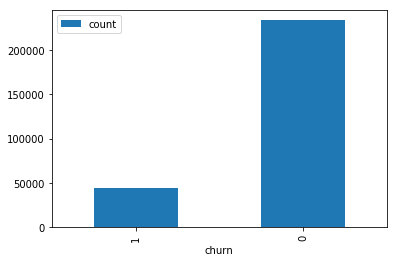

In [24]:
# In a graph, we show the ratio of the churn = 1 and churn = 0
(df.groupby("churn").count().select('churn', 'count')
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar'))

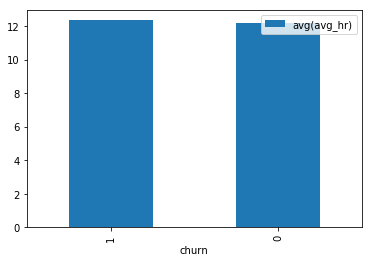

In [25]:
#Could we calculate what is the average number of hours that each one listens to music? ... then we can see it
avg_song_time = df.filter(df.page == "NextSong").withColumn("hour", hour(from_unixtime(col('ts')/1000)))

avg_song_time = avg_song_time.select(["userId", "hour"]) \
                    .groupBy('userID') \
                    .agg({'hour': 'avg'})

avg_song_time = avg_song_time.withColumnRenamed("avg(hour)", "avg_hr")

df = df.join(avg_song_time, on = 'userId', how = 'left')

(df.groupby("churn").avg().select('churn', 'avg(avg_hr)')
                .toPandas()
                .set_index('churn')
                .plot(kind = 'bar'))

In [26]:
#comparison between premium services (paid) and free service (not paid) in users who abandoned
df.groupby("churn", "level").count().toPandas()

,churn,level,count
0,0,free,43333
1,0,paid,189957
2,1,paid,32476
3,1,free,12388


In [27]:
df.groupby('status').count().toPandas()

,status,count
0,307,23184
1,404,252
2,200,254718


In [28]:
df.groupby('method').count().toPandas()

,method,count
0,PUT,257818
1,GET,20336


In [29]:
#We were able to observe that users with premium service are more than those with free service
#in both groups. Now let's review the relationship between the upgrade and downgrade of users 
#who have lost the rating

In [30]:
#upgrade vs downgrade
df.filter(df.page == 'Downgrade').groupby('churn').count().toPandas()

,churn,count
0,1,337
1,0,1718


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [31]:
#Removing the less useful columns
df_new = df.drop('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'location', 'method',
                 'registration', 'sessionId', 'song', 'avg_hr')

In [32]:
df_new.toPandas().head()

,userId,level,page,status,ts,userAgent,churn
0,100010,free,NextSong,200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
1,100010,free,NextSong,200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
2,100010,free,NextSong,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
3,100010,free,Thumbs Up,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0
4,100010,free,NextSong,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",0


In [33]:
# StringIndexer codifica una columna de cadenas de etiquetas en una columna de índices de etiquetas 
# build string indexer
levelIndexer = StringIndexer(inputCol='level', outputCol='levelIndex')
userAgentIndexer = StringIndexer(inputCol="userAgent", outputCol='userAgentIndex')
pageIndexer = StringIndexer(inputCol="page", outputCol='pageIndex')

#One-hot encoding maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value 
#indicating the presence of a specific feature value from among the set of all feature value
levelVec = OneHotEncoder(inputCol='levelIndex', outputCol='levelVec')
userAgentVec = OneHotEncoder(inputCol='userAgentIndex', outputCol='userAgentVec')
pageVec = OneHotEncoder(inputCol='pageIndex', outputCol='pageVec')

In [34]:
# Renaming churn
df_new = df_new.withColumnRenamed("churn", "label")

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
#split the data into train and test set
train, test = df_new.randomSplit([0.8, 0.2], seed = 42)

In [36]:
# Create vector from feature data
assembler  = VectorAssembler(inputCols = ["levelVec", "userAgentVec", "pageVec", "status", "ts"], outputCol = "features")

In [37]:
# MinMaxScaler transforms a dataset of Vector rows, rescaling each feature to a specific range (often [0, 1])
# Scale each column
scalar = MinMaxScaler(inputCol="features", outputCol="ScaledFeatures")

In [38]:
# funtion model machine learning evaluations 
def modelEvaluations(model, metric, data):
    """ Evaluate a machine learning model's performance 
        Input: 
            model - pipeline object
            metric - the metric of the evaluations
            data - data being evaluated
        Output:
            [score, confusion matrix]
    """
    # generate predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # calcualte score
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    return [score, confusion_matrix]

In [39]:
# Train a RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="ScaledFeatures", numTrees=10)

# using grid search with entropy and gini
param_grid = ParamGridBuilder() \
            .addGrid(rf.impurity,['entropy', 'gini']) \
            .addGrid(rf.maxDepth,[5, 10]) \
            .addGrid(rf.seed, [42]).build()

pipeline = Pipeline(stages=[levelIndexer, userAgentIndexer, pageIndexer, levelVec, userAgentVec, pageVec, assembler, scalar, rf])

crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
rf_model = crossval.fit(train)
 
f1_rf, conf_mtx_rf = modelEvaluations(rf_model, 'f1', test)
print('The F1 score for the Random forest model is:', f1_rf)
conf_mtx_rf

The F1 score for the Random forest model is: 0.8532332173065494


,label,0.0,1.0
0,1,6496,2570
1,0,46411,65


From the evaluation of the previous model we can see that the increase in the gradient produces a better F1 score, reaching 85.32%. Remaining the same margin even to be able to continue improving the algorithm.

It would be very interesting to analyze the daily users and the monthly, quarterly and semi-annual users to see how consistent they have been during the year, to see if they change a lot from premium service to free service, Also, not only to predict those who would cancel as they were. did previously, but also to predict those who go down from premium service to free service and their trend over time to determine what could have affected him to change his mind.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.